<a href="https://colab.research.google.com/github/Andrewzhuyx/ESE546-Final-Project/blob/main/VAE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/ESE 546 Final Project/"

VAE.ipynb


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torchvision

SIDE_LENGTH=32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(SIDE_LENGTH)
     ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



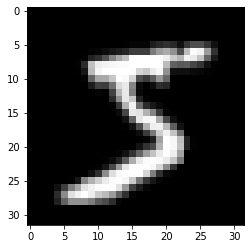

In [ ]:
import matplotlib.pyplot as plt
first_image = trainset[0][0].reshape((32,32))
plt.imshow(first_image, cmap='gray')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

#TODO: Create ib_encoder
def conv_output(n_layers, i, p, k, s):
      print(n_layers, np.floor((i + 2*p - k) / s) + 1)
      if n_layers == 1:
        return int(np.floor((i + 2*p - k) / s) + 1)
      else:
        return conv_output(n_layers - 1, np.floor((i + 2*p - k) / s) + 1, p, k, s)

class vae_encoder(nn.Module):
    def __init__(self, n_layers, in_dim=784, z_dim=32, kernel_size=3, stride=2, use_fc=False):
        super(vae_encoder, self).__init__()
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_dim = in_dim
        self.z_dim = z_dim
        self.use_fc = use_fc
        self.in_ch = [16 * 2**k for k in range(self.n_layers)]
        self.fc_dims = [in_dim // 2**k for k in range(self.n_layers)]
        layers = []
        if use_fc == True:
          for dim in self.fc_dims:
            layers.append(nn.Linear(dim, dim // 2))
            layers.append(nn.ReLU())
          self.layers = nn.Sequential(*layers)
        else:
          prev = 1
          for ch in self.in_ch:
            layers.append(nn.Conv2d(prev, ch, kernel_size=kernel_size, stride=stride, padding=1))
            layers.append(nn.ReLU())
            prev = ch
          self.layers = nn.Sequential(*layers)
        self.conv_output_dim = conv_output(self.n_layers, np.sqrt(self.in_dim), 1, self.kernel_size, self.stride)
        print("conv_output_dim", self.conv_output_dim)
        if use_fc == True:
          self.fc_mu = nn.Linear(self.fc_dims[-1] // 2, z_dim)
          self.fc_logvar = nn.Linear(self.fc_dims[-1] // 2, z_dim)
        else: 
          self.fc_mu = nn.Linear(int(self.conv_output_dim**2 *8 * 2**self.n_layers), z_dim)
          self.fc_logvar = nn.Linear(int(self.conv_output_dim**2 * 8 * 2**self.n_layers), z_dim)
        self.dist = torch.distributions.Normal(0, 1)
        # CUDA hack for above?
        # https://avandekleut.github.io/vae/
        print("Encoder Layers")
        print(self.layers)
        print(self.fc_mu)
        print(self.fc_logvar,'\n')

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        if self.use_fc == True:
          x = x.reshape((-1, self.in_dim))
        #print(x.shape)
        x = self.layers(x)
          #print(x.shape)
        if self.use_fc == False:
          x = x.reshape((x.shape[0],-1))  
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        self.kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp()) 

        #z = mu + sigma*self.dist.sample(mu.shape) 
        #self.kl = (sigma + mu**2 - torch.log(sigma) - 1. - sigma).sum()
        #print("encoder complete")
        return z
         

class decoder(nn.Module):
    def __init__(self, conv_output_dim, n_layers, out_dim=784, z_dim=32, kernel_size=2, stride=2, use_fc=False):
        super(decoder, self).__init__()
        self.conv_output_dim = conv_output_dim
        self.n_layers = n_layers
        self.out_dim = out_dim
        self.z_dim = z_dim
        self.use_fc = use_fc
        if self.use_fc == True:
          self.fc = nn.Linear(z_dim, out_dim // 2**(self.n_layers))
        else:
          self.fc = nn.Linear(z_dim, self.conv_output_dim ** 2 * 2 ** self.n_layers)      
        self.in_ch = [2 ** self.n_layers // 2**k for k in range(n_layers)]
        self.fc_dims = [out_dim // 2**(k+1) for k in range(self.n_layers)][::-1]
        print(self.fc_dims)
        layers = []
        if use_fc:
          for dim in self.fc_dims:
            layers.append(nn.Linear(dim, dim * 2))
            layers.append(nn.ReLU())
          self.layers = nn.Sequential(*layers)
        else:
          for ch in self.in_ch:
            layers.append(nn.ConvTranspose2d(ch, ch // 2,kernel_size=kernel_size, stride=stride, padding = 1))
            if (ch // 2 != 1):
              layers.append(nn.ReLU())
            else:
              layers.append(nn.Sigmoid())
          self.layers = nn.Sequential(*layers)
        print("Decoder Layers:")
        print(self.fc)
        print(self.layers, '\n')

    def forward(self, x):
        x = self.fc(x)
        if self.use_fc == False:
         x = x.reshape((x.shape[0], -1, self.conv_output_dim, self.conv_output_dim))
        #print(x.shape)
        x = self.layers(x)
        return x


class variational_autoencoder(nn.Module):
    def __init__(self, n_layers, in_dim=784, z_dim=32, enc_k =3, dec_k=2, enc_stride=2, dec_stride=2, use_fc=False):
        super(variational_autoencoder, self).__init__()
        self.encoder = vae_encoder(n_layers, in_dim, z_dim, enc_k, enc_stride, use_fc)
        # out_dim is in_dim for decoder
        self.decoder = decoder(self.encoder.conv_output_dim, n_layers, in_dim, z_dim, dec_k, dec_stride, use_fc)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encoder(x)
        self.latent = z
        x_hat = self.decoder(z)
        return x_hat



#test_enc = encoder(4)
#test_dec = decoder(4) 
#test_vae = variational_autoencoder(2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torchvision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def train_vae(trainloader, testloader, net, epochs=10, beta=1, lr=1e-3, weight_decay=0):
    ep_losses = []
    x_arr = []
    x_hat_arr = []
    opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    net.train()
    criterion = nn.BCELoss()
    for epoch in range(epochs):
        ep_loss = 0
        for x, y in trainloader:
            x = x.to(device)
            y = y.to(device)
            opt.zero_grad()
            x_hat = net(x)
            flattened_dim = net.encoder.in_dim
            # print(x_hat.shape)
            mseloss = criterion(x_hat.squeeze(), x.squeeze())
            klloss = beta * net.encoder.kl
            
            loss = mseloss + klloss
            loss.backward()            
            opt.step()
            # print("MSE Loss" + str(mseloss.item()))
            # print("KL Loss" + str(klloss.item()))
            # print(net.latent)
            ep_loss += loss.item()
        ep_loss /= len(trainloader)
        print("Epoch {}: {}".format(epoch, ep_loss))
        ep_losses.append(ep_loss) 
        for x, y in trainloader:
          with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            x_hat = net(x)
            x_arr.append(x[0])
            x_hat_arr.append(x_hat[0])
          break
    f, ax = plt.subplots(5, 2) 
    matplotlib.rcParams['figure.figsize'] = [10, 10] 
    for i in range(5):
      ax[i][0].imshow(x_arr[i+epochs-5].reshape((-1, 32, 32)).squeeze().cpu(), aspect='auto')
      ax[i][1].imshow(x_hat_arr[i+epochs-5].reshape((-1, 32, 32)).squeeze().cpu(), aspect='auto')   
    
    return net

3 16.0
2 8.0
1 4.0
conv_output_dim 4
Encoder Layers
Sequential(
  (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)
Linear(in_features=1024, out_features=8, bias=True)
Linear(in_features=1024, out_features=8, bias=True) 

[128, 256, 512]
Decoder Layers:
Linear(in_features=8, out_features=128, bias=True)
Sequential(
  (0): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): Sigmoid()
) 

Epoch 0: 0.26632013299000035
Epoch 1: 0.20047159726495173
Epoch 2: 0.18618138129713693
Epoch 3: 0.1792481300323757
Epoch 4: 0.17608255532377565
Epoch 5: 0.17417981080027786
Epoch 6: 0.

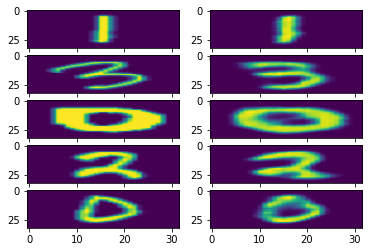

In [ ]:
model = variational_autoencoder(3, in_dim=SIDE_LENGTH**2, enc_k = 4, dec_k=4, z_dim=8, use_fc=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
net = train_vae(trainloader, testloader, model, epochs=20, beta=1/32/32/64, lr=1e-3, weight_decay=0)